# Set up the environment

# Training data preparation

In [1]:
!mkdir raw_datasets

mkdir: impossible de créer le répertoire «raw_datasets»: Le fichier existe


## Download datasets

In [26]:
# Download datasets

%cd raw_datasets/
"""
!unzip -q -o REID2019.zip -d REID2019/
!unzip -q -o "REID2019/*".zip -d REID2019/
!rm REID2019/*.zip
"""
#!tar --keep-newer-files -xzf *.tar.gz -C ./ 2>/dev/null

%cd ../

/home/21804803t@univ-tours.local/Deep-Agora/deep_learning_lab/raw_datasets
/home/21804803t@univ-tours.local/Deep-Agora/deep_learning_lab


## Patch the datasets

In [3]:
#!rm -r _*_ # Delete the patched datasets

In [4]:
## Patch the datasets

import training_data.pipelines as pipeline

configured_labels = (['TextRegion'], ['TextLine'], ['ImageRegion'])#, ['TextLine'], ['TextRegion', 'TextLine']) # Atomic labels are to be promoted

to_be_patched = {
    #d : pipeline.selectAnnotationsFrom(d) # Interactive
    d : configured_labels # Automatic (Warning: Depends on the datasets below)
    for d in (
        #'reid',
        #'fcr',
        #'bcs_a', 'bcc_a',
        #'bcs_b', 'bcc_b',
        #'bcs_e', 'bcc_e',
        #'bcs_h', 'bcc_h',
        #'bcs_n', 'bcc_n',
        #'bcs_s', 'bcc_s',
        #'bcs_u', 'bcc_u',
        #'bcs_un','bcc_un',
        #'bcc_bh',
    )
}

for dataset, chosen_annotations in to_be_patched.items():
    for chosen_labels in chosen_annotations:
        pipeline.annotationsToMasks(
            src= dataset,
            names_labels= chosen_labels,
            verbose= 2
        )

# Deep learning lab

In [8]:
## Imports

from dh_segment_torch.config import Params
from dh_segment_torch.data import DataSplitter
from dh_segment_torch.data.annotation import AnnotationWriter
from dh_segment_torch.training import Trainer
from dh_segment_torch.inference import PredictProcess
from dh_segment_torch.post_processing import PostProcessingPipeline

In [9]:
import torch
import os

print("=== CUDA device selection ===")

assert torch.cuda.device_count() >= 1

print("device 0: ",torch.cuda.get_device_properties(0)) 
print("device 1: ",torch.cuda.get_device_properties(1))

cuda_device = 0
cuda_device_str = str(cuda_device)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=cuda_device_str
torch.cuda.set_device(cuda_device)

=== CUDA device selection ===
device 0:  _CudaDeviceProperties(name='RTX A6000', major=8, minor=6, total_memory=48685MB, multi_processor_count=84)
device 1:  _CudaDeviceProperties(name='Quadro RTX 8000', major=7, minor=5, total_memory=48601MB, multi_processor_count=72)


In [10]:
print("=== torch cuda ===")

print("cuda:",torch.version.cuda," device = ",torch.cuda.current_device())
print("The selected GPU has %.2f GB of memory."%(torch.cuda.get_device_properties(0).total_memory//1024**2/1000))
print("torch:",torch.__version__)

# type "nvidia-smi" on linux prompt for info about CUDA
print("The GPU has %.2f GB of memory."%(torch.cuda.get_device_properties(0).total_memory//1024**2/1000))

=== torch cuda ===
cuda: 11.3  device =  0
The selected GPU has 48.69 GB of memory.
torch: 1.12.1
The GPU has 48.69 GB of memory.


In [11]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageColor
import os, glob, cv2

## Training parameters

In [12]:
## Loading data

folder_name = '_TextLine_' # Change this parameter to your project name

params = {
    'data_path' : os.path.join(folder_name, 'data'), # Path to write the data
    'data_splitter': {'train_ratio': 0.80, 'val_ratio': 0.10, 'test_ratio': 0.10}, # splitting ratio of the data
}

data_path = params.pop("data_path")

In [13]:
## Process parameters

model_name = "model_"+folder_name.replace('_', '')

relative_path = params.pop("relative_path", True)

params.setdefault("labels_dir", os.path.join(data_path, "labels"))
labels_dir = params.get("labels_dir")

params.setdefault("images_dir", os.path.join(data_path, "images"))
images_dir = params.get("images_dir")

params.setdefault("csv_path", os.path.join(data_path, "data.csv"))

data_splitter_params = params.pop("data_splitter", None)
train_csv_path = params.pop("train_csv", os.path.join(data_path, "train.csv"))
val_csv_path = params.pop("val_csv", os.path.join(data_path, "val.csv"))
test_csv_path = params.pop("test_csv", os.path.join(data_path, "test.csv"))

## List labels and images in CSV file

labels_list = sorted(glob.glob(os.path.join(labels_dir, '*.*')))
images_list = sorted(glob.glob(os.path.join(images_dir, '*.*')))

data = pd.DataFrame({'image': images_list, 'label': labels_list})
data.to_csv(params['csv_path'], header=False, index=False)

if relative_path:
    data['image'] = data['image'].apply(lambda path: os.path.join("images", os.path.basename(path)))
    data['label'] = data['label'].apply(lambda path: os.path.join("labels", os.path.basename(path)))
    
## Divide data set in train, validation and test sets
if data_splitter_params:
    data_splitter = DataSplitter.from_params(data_splitter_params)
    data_splitter.split_data(data, train_csv_path, val_csv_path, test_csv_path)

In [14]:
## Training params

params = {
    "color_labels": {"label_json_file": os.path.join(data_path, "classfile.json")}, # Color labels produced before
    "train_dataset": {
        "type": "image_csv", # Image csv dataset
        "csv_filename": os.path.join(data_path, "train.csv"),
        "base_dir": data_path,
        "repeat_dataset": 4, # Repeat 4 times the data since we have little
        "compose": {"transforms": [{"type": "fixed_size_resize", "output_size": 1e6}]} # Resize to a fixed size, could add other transformations.
    },
    "val_dataset": {
        "type": "image_csv", # Validation dataset
        "csv_filename": os.path.join(data_path, "val.csv"),
        "base_dir": data_path,
        "compose": {"transforms": [{"type": "fixed_size_resize", "output_size": 1e6}]}
    },
    "model": { # Model definition, original dhSegment
        "encoder": "resnet50", 
        "decoder": {
            "decoder_channels": [512, 256, 128, 64, 32],
            "max_channels": 512
        }
    },
    "metrics": [['miou', 'iou'], ['iou', {"type": 'iou', "average": None}], 'precision'], # Metrics to compute
    "optimizer": {"lr": 1e-4}, # Learning rate
    "lr_scheduler": {"type": "exponential", "gamma": 0.9995}, # Exponential decreasing learning rate
    "val_metric": "+miou", # Metric to observe to consider a model better than another, the + indicates that we want to maximize
    "early_stopping": {"patience": 4}, # Number of validation steps without increase to tolerate, stops if reached
    "model_out_dir": model_name, # Path to model output
    "num_epochs": 100, # Number of epochs for training
    "evaluate_every_epoch": 5, # Number of epochs between each validation of the model
    "batch_size": 4, # Batch size (to be changed if the allocated GPU has little memory)
    "num_data_workers": 0,
    "track_train_metrics": False,
    "loggers": [
        {"type": 'tensorboard', "log_dir": os.path.join('.', 'tensorboard', 'log'), "log_every": 5, "log_images_every": 10}, # Tensorboard logging
        ]
}

## Training

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
%tensorboard --logdir tensorboard/log

In [14]:
## Train

trainer = Trainer.from_params(params)
trainer.train()

{'color_labels': {'label_json_file': '_TextLine_/data/classfile.json'}, 'train_dataset': {'type': 'image_csv', 'csv_filename': '_TextLine_/data/train.csv', 'base_dir': '_TextLine_/data', 'repeat_dataset': 4, 'compose': {'transforms': [{'type': 'fixed_size_resize', 'output_size': 1000000.0}]}}, 'val_dataset': {'type': 'image_csv', 'csv_filename': '_TextLine_/data/val.csv', 'base_dir': '_TextLine_/data', 'compose': {'transforms': [{'type': 'fixed_size_resize', 'output_size': 1000000.0}]}}, 'model': {'encoder': 'resnet50', 'decoder': {'decoder_channels': [512, 256, 128, 64, 32], 'max_channels': 512}}, 'metrics': [['miou', 'iou'], ['iou', {'type': 'iou', 'average': None}], 'precision'], 'optimizer': {'lr': 0.0001}, 'lr_scheduler': {'type': 'exponential', 'gamma': 0.9995}, 'val_metric': '+miou', 'early_stopping': {'patience': 4}, 'model_out_dir': 'model_TextLine', 'num_epochs': 100, 'evaluate_every_epoch': 5, 'batch_size': 4, 'num_data_workers': 0, 'track_train_metrics': False, 'loggers': [

epoch 0: loss=???:   0%|          | 0/100 [00:00<?, ?it/s]

iter=0: loss=???: 0it [00:00, ?it/s]

iter=792: loss=???: 0it [00:00, ?it/s]

iter=1584: loss=???: 0it [00:00, ?it/s]

iter=2376: loss=???: 0it [00:00, ?it/s]

iter=3168: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

iter=3960: loss=???: 0it [00:00, ?it/s]

iter=4752: loss=???: 0it [00:00, ?it/s]

iter=5544: loss=???: 0it [00:00, ?it/s]

iter=6336: loss=???: 0it [00:00, ?it/s]

iter=7128: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

iter=7920: loss=???: 0it [00:00, ?it/s]

iter=8712: loss=???: 0it [00:00, ?it/s]

iter=9504: loss=???: 0it [00:00, ?it/s]

iter=10296: loss=???: 0it [00:00, ?it/s]

iter=11088: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

iter=11880: loss=???: 0it [00:00, ?it/s]

iter=12672: loss=???: 0it [00:00, ?it/s]

iter=13464: loss=???: 0it [00:00, ?it/s]

iter=14256: loss=???: 0it [00:00, ?it/s]

iter=15048: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

iter=15840: loss=???: 0it [00:00, ?it/s]

iter=16632: loss=???: 0it [00:00, ?it/s]

iter=17424: loss=???: 0it [00:00, ?it/s]

iter=18216: loss=???: 0it [00:00, ?it/s]

iter=19008: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

iter=19800: loss=???: 0it [00:00, ?it/s]

iter=20592: loss=???: 0it [00:00, ?it/s]

iter=21384: loss=???: 0it [00:00, ?it/s]

iter=22176: loss=???: 0it [00:00, ?it/s]

iter=22968: loss=???: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

In [15]:
with open("notification.txt", "w") as f:
    f.write("entraînement fini")

# Tests

## Inference parameters

In [15]:
## Inference params

dataset_params = {
    "type": "folder",
    "folder": os.path.join(data_path, 'images'),
    "pre_processing": {"transforms": []}
}

model_params = {
    "model": {
            "encoder": "resnet50",
            "decoder": {"decoder_channels": [512, 256, 128, 64, 32], "max_channels": 512}
        },
        "num_classes": 2,
        "model_state_dict": sorted(glob.glob(os.path.join(model_name, 'best_model_checkpoint_miou=*.pth')))[-1],
        "device": "cuda:0"
}

process_params = Params({
    'data': dataset_params,
    'model': model_params,
    'batch_size': 4,
    'num_workers': 0,
    'add_path': True
})

## Inference

In [ ]:
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

predict_annots = PredictProcess.from_params(process_params)
predict_annots.process_to_probas_files(output_dir)

## Visualise the results

In [17]:
results = [np.load(path) for path in sorted(glob.glob(os.path.join(output_dir, '*.npy')))]
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in sorted(glob.glob(os.path.join(data_path, 'images', '*.*')))]

### Comparaison between the original image and the probability map

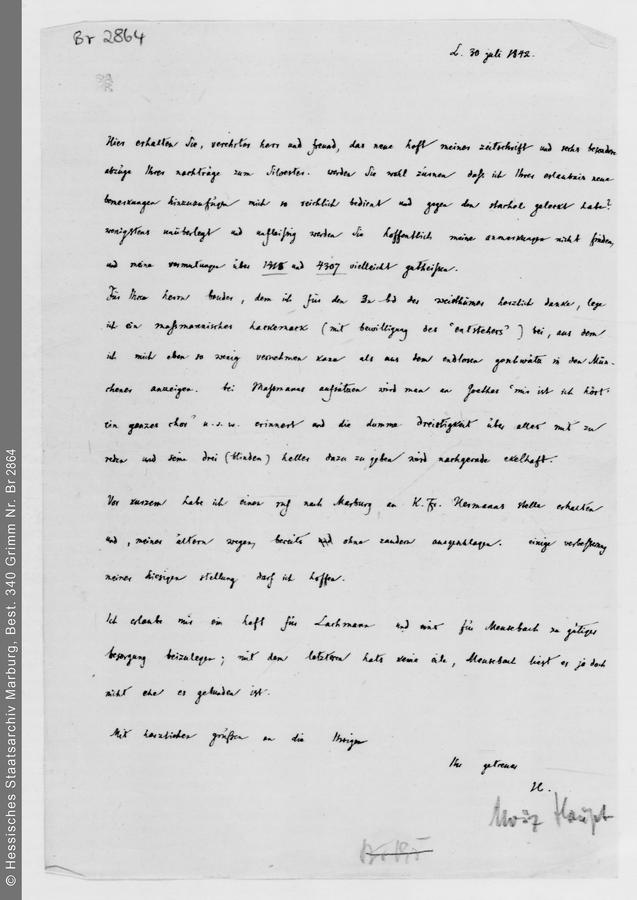

In [114]:
image_nb = 5

result = results[image_nb]
image = images[image_nb]

Image.fromarray(image)

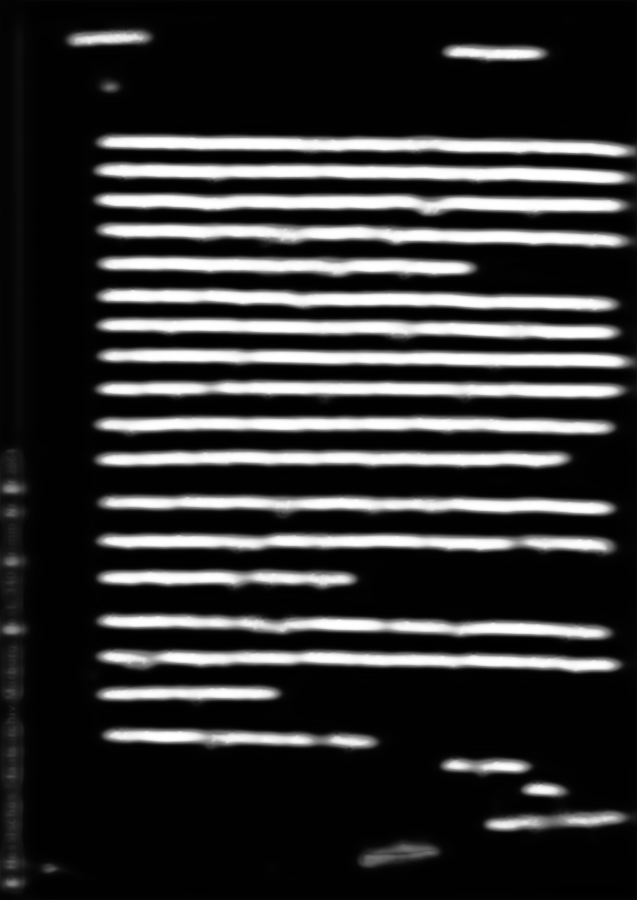

In [115]:
class_nb = 1

Image.fromarray((np.around(result[class_nb]*255)).astype('uint8'))

### Focus on the best predictions

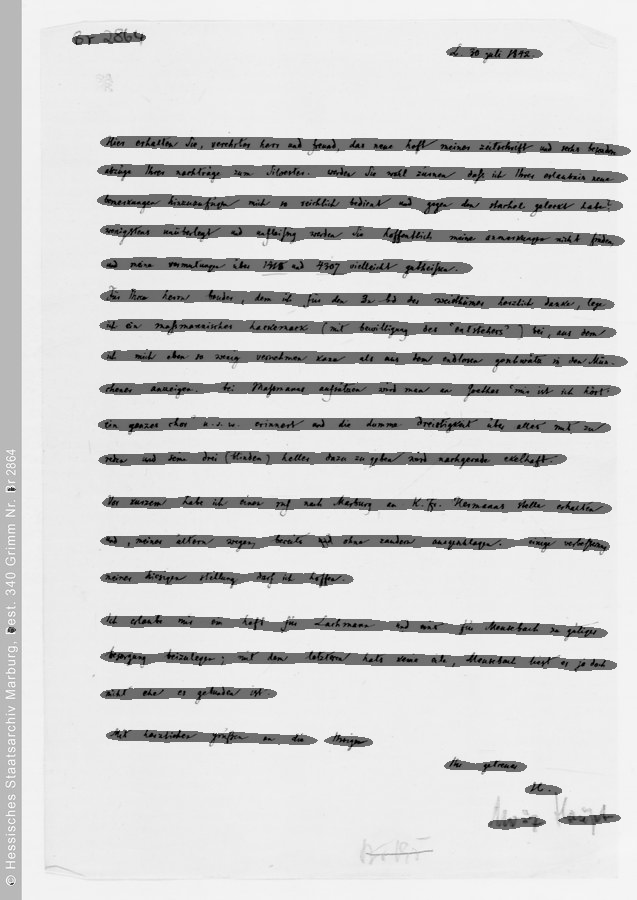

In [116]:
colors = (255, 0)

def postprocess(preds):
    best_preds = np.argmax(preds, axis=0).astype('uint8')
    canvas = np.zeros((best_preds.shape[0], best_preds.shape[1], 3)).astype('uint8')
    for i, color in enumerate(colors):
        canvas[best_preds == i] = color
    return canvas

pred = postprocess(result)
Image.fromarray(pred//2 + image//2)

### Bounding box

In [117]:
from matplotlib import pyplot as plt

In [122]:
def findContours(preds):
    # Threshold the image to create a binary image
    grey_preds = cv2.cvtColor(preds, cv2.COLOR_BGR2GRAY)
    ret, thresh_preds = cv2.threshold(grey_preds, 1, 255, cv2.THRESH_BINARY)
    
    # Loop over the contours and draw bounding boxes around them
    contours, hierarchy = cv2.findContours(thresh_preds, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def drawBoxes(preds, image= None):
    if image is None:
        canvas = np.zeros((preds.shape[0], preds.shape[1], 3)).astype('uint8')
    else:
        canvas = image.copy()
    contours = findContours(preds)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(canvas,(x,y),(x+w,y+h),(0,255,0),2)
    return canvas


def cutVignettes(preds, image, w_seuils= 0, h_seuils= 0):
    contours = findContours(preds)
    pred_cuts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w > w_seuils and h > h_seuils:
            pred_cuts.append(image[y:y+h, x:x+w])
    return pred_cuts

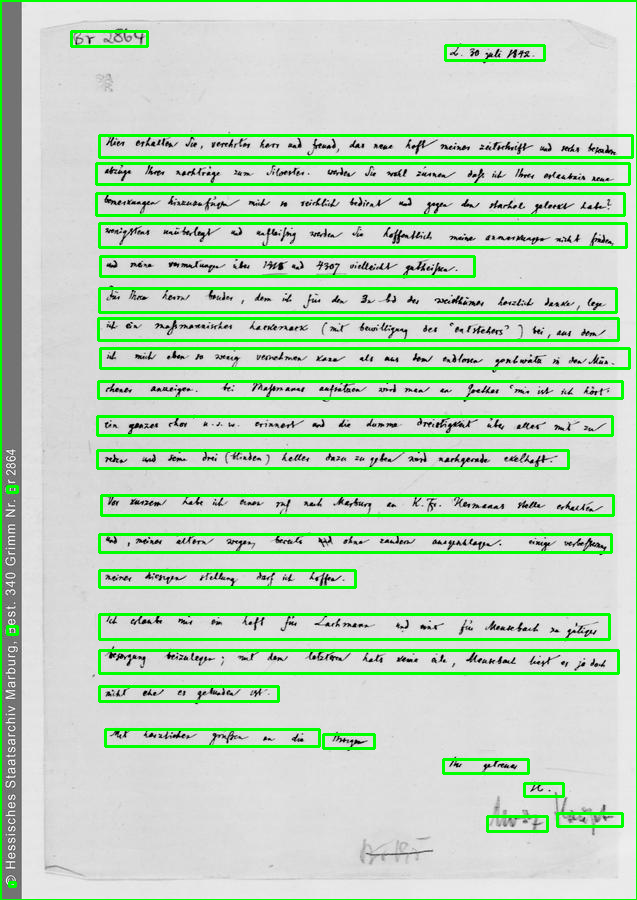

In [123]:
image_segmented = drawBoxes(pred, image)
Image.fromarray(image_segmented)

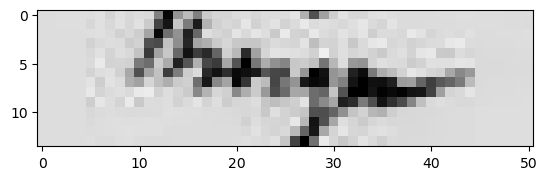

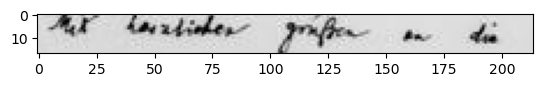

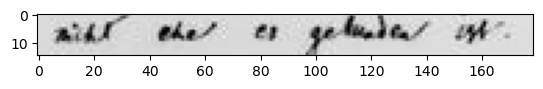

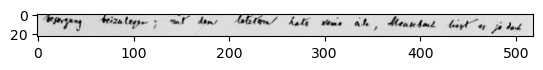

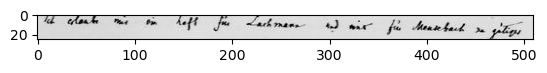

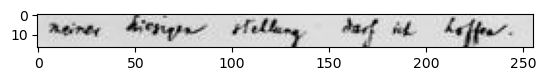

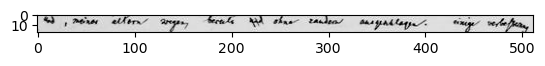

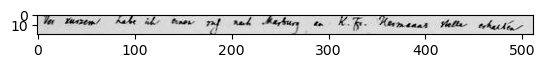

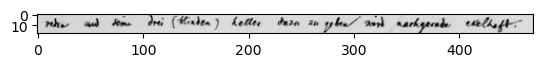

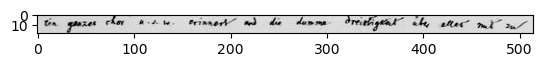

In [134]:
vignettes = cutVignettes(pred, image, w_seuils= 10)

for it in range(5,15):
    plt.imshow(Image.fromarray(vignettes[it]))
    plt.show()